# Simulation

In [1]:
import os
import time
import torch
import scipy
import csv
import time

from torch import nn, Tensor
from tqdm import trange
from dataset.dataset import *
from model_toy import *
from utils import *
from discrete_solver import *
from torch.utils.data import DataLoader


# flow_matching
from flow_matching.path import MixtureDiscreteProbPath
from flow_matching.path.scheduler import PolynomialConvexScheduler
from flow_matching.utils import ModelWrapper
from flow_matching.loss import MixturePathGeneralizedKL
from flow_matching.path.scheduler.scheduler import SchedulerOutput, ConvexScheduler

# visualization
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')

torch.manual_seed(42)

Using cpu.


### Uniform source distribution

In [ ]:

vocab_size = 8
delta = 0.05
scheduler = PolynomialConvexScheduler(n=1)
path = MixtureDiscreteProbPath(scheduler=scheduler)


def total_variation(p, q):
    return 0.5 * np.sum(np.abs(p - q))

n_samples_eval = 100000
n_repeats = 10  
k_values = [1, 2, 3, 4, 5]  
N_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50]
samplers = ['Tauleaping','Euler','TimeCorrected','LocationCorrected']

# Store TV results: dict[k] -> dict[sampler_name] -> list[tv_values]
tv_results = {k: {name: {} for name in samplers} for k in k_values}
# Store timing results
time_results = {k: {name: {} for name in samplers} for k in k_values}

# function to convert joint state to index
def joint_to_index(joint_data):
    return joint_data[:, 0] * (vocab_size ** 2) + joint_data[:, 1] * vocab_size + joint_data[:, 2]

# Joint state space size
joint_space_size = vocab_size ** 3



# Load existing CSV
csv_filename = "tv_time_all_results_mask.csv"
df = pd.read_csv(csv_filename)

for k in k_values:
    dimension = 3 * k
    # Generate ground truth: real data empirical distribution
    real_data_cache = generate_3k_discrete_data(n=1000000, K=k)
    real_joint = real_data_cache[:, :3]
    real_indices = joint_to_index(real_joint)
    # Compute real distribution (ground truth)
    unique_values_real, counts_real = np.unique(real_indices, return_counts=True)
    probs_real_full = np.zeros(joint_space_size)
    for val, prob in zip(unique_values_real, counts_real / len(real_indices)):
        probs_real_full[int(val)] = prob
    
    # Load model (only once per k)
    logit_model = ToyMLP(vocab_size=vocab_size, hidden_dim=256, length=dimension)
    model_path = os.path.join("./ckpts", f"toy_mask{k}_step200000", f"ckpt.pth")

    if not os.path.exists(model_path):
        print(f"Model not found at {model_path}")
        continue
    
    ckpt_posterior = torch.load(model_path, map_location=device)
    logit_model.load_state_dict(ckpt_posterior)
    logit_model.eval()
    posterior_model = WrappedModel(logit_model)
    
    for N_step in N_values:
        print(f"\n  N={N_step}")

        for sampler in samplers:
            print(f"Processing sampler = {sampler}")
            tv_list = []
            time_list = []
            for rep in range(n_repeats):
                x_init = torch.randint(size=(n_samples_eval, dimension), high=vocab_size, device=device)
                with torch.no_grad():
                    start_time = time.time()
                    if sampler == 'Uniformization':
                        solver = MixtureDiscreteUniformizationSolver(
                            model=posterior_model, path=path, vocabulary_size=vocab_size)
                        sol, _ = solver.sample(x_init=x_init, delta=delta, verbose=False)
                        
                    elif sampler == 'Tauleaping':
                        solver = MixtureDiscreteTauleapingSolver(
                            model=posterior_model, path=path, vocabulary_size=vocab_size)
                        sol, _ = solver.sample(x_init=x_init, N=N_step, delta=delta, verbose=False)
                        
                    elif sampler == 'Euler':
                        solver = MixtureDiscreteEulerSolver(
                            model=posterior_model, path=path, vocabulary_size=vocab_size)
                        sol, _ = solver.sample(x_init=x_init, N=N_step, delta=delta, verbose=False)

                    elif sampler == 'TimeCorrected':
                        solver = MixtureDiscreteTimeCorrectedSolver(
                            model=posterior_model, path=path, vocabulary_size=vocab_size)
                        sol, _ = solver.sample(x_init=x_init, N=N_step, delta=delta, verbose=False)
                        
                    elif sampler == 'LocationCorrected':
                        solver = MixtureDiscreteLocationCorrectedSolver(
                            model=posterior_model, path=path, vocabulary_size=vocab_size)
                        sol, _ = solver.sample(x_init=x_init, N=N_step, delta=delta, verbose=False)

                    sample_time = time.time() - start_time
                    # Compute empirical distribution of generated samples
                    sol_joint = sol[:, :3].cpu().numpy()
                    sol_indices = joint_to_index(sol_joint)
                    unique_values_sol, counts_sol = np.unique(sol_indices, return_counts=True)
                    probs_sol_full = np.zeros(joint_space_size)
                    for val, prob in zip(unique_values_sol, counts_sol / len(sol_indices)):
                        probs_sol_full[int(val)] = prob
                    
                    # Compute TV distance
                    tv = total_variation(probs_real_full, probs_sol_full)

                    tv_list.append(tv)
                    time_list.append(sample_time)
            # Average over repeats
            tv_mean = np.mean(tv_list)
            tv_std = np.std(tv_list)
            time_mean = np.mean(time_list)
            time_std = np.std(time_list)
            tv_results[k][sampler][N_step] = {'mean': tv_mean, 'std': tv_std, 'all': tv_list}
            time_results[k][sampler][N_step] = {'mean': time_mean, 'std': time_std, 'all': time_list}

            print(f"  k={k}, Sampler={sampler}, N_step={N_step}, TV={tv_mean:.6f}±{tv_std:.6f}, Time={time_mean:.2f}±{time_std:.2f}s")
# Save to CSV
csv_filename = "tv_time_all_results_uniform.csv"
with open(csv_filename, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["k", "dimension", "N", "sampler", "tv_mean", "tv_std", "time_mean", "time_std"])
    for k in k_values:
        for N in N_values:
            for sampler in samplers:
                res_tv = tv_results[k][sampler].get(N)
                res_time = time_results[k][sampler].get(N)
                if res_tv is not None and res_time is not None:
                    writer.writerow([k, 3*k, N, sampler, 
                                     res_tv['mean'], res_tv['std'],
                                     res_time['mean'], res_time['std']])
                else:
                    writer.writerow([k, 3*k, N, sampler, None, None, None, None])


print(f"\n{'='*80}")
print(f"CSV file saved: {csv_filename}")
print(f"{'='*80}")


  N=1
Processing sampler = Tauleaping
  k=1, Sampler=Tauleaping, N_step=1, TV=0.250341±0.001113, Time=0.21±0.02s
Processing sampler = Euler
  k=1, Sampler=Euler, N_step=1, TV=0.244079±0.001733, Time=0.20±0.02s
Processing sampler = TimeCorrected
  k=1, Sampler=TimeCorrected, N_step=1, TV=0.242080±0.001756, Time=0.21±0.01s
Processing sampler = LocationCorrected
  k=1, Sampler=LocationCorrected, N_step=1, TV=0.218805±0.001595, Time=0.41±0.01s

  N=2
Processing sampler = Tauleaping
  k=1, Sampler=Tauleaping, N_step=2, TV=0.165855±0.001638, Time=0.43±0.04s
Processing sampler = Euler
  k=1, Sampler=Euler, N_step=2, TV=0.151427±0.001655, Time=0.38±0.01s
Processing sampler = TimeCorrected
  k=1, Sampler=TimeCorrected, N_step=2, TV=0.118163±0.001455, Time=0.40±0.01s
Processing sampler = LocationCorrected
  k=1, Sampler=LocationCorrected, N_step=2, TV=0.081542±0.001054, Time=0.72±0.02s

  N=3
Processing sampler = Tauleaping
  k=1, Sampler=Tauleaping, N_step=3, TV=0.129154±0.001497, Time=0.63±0.

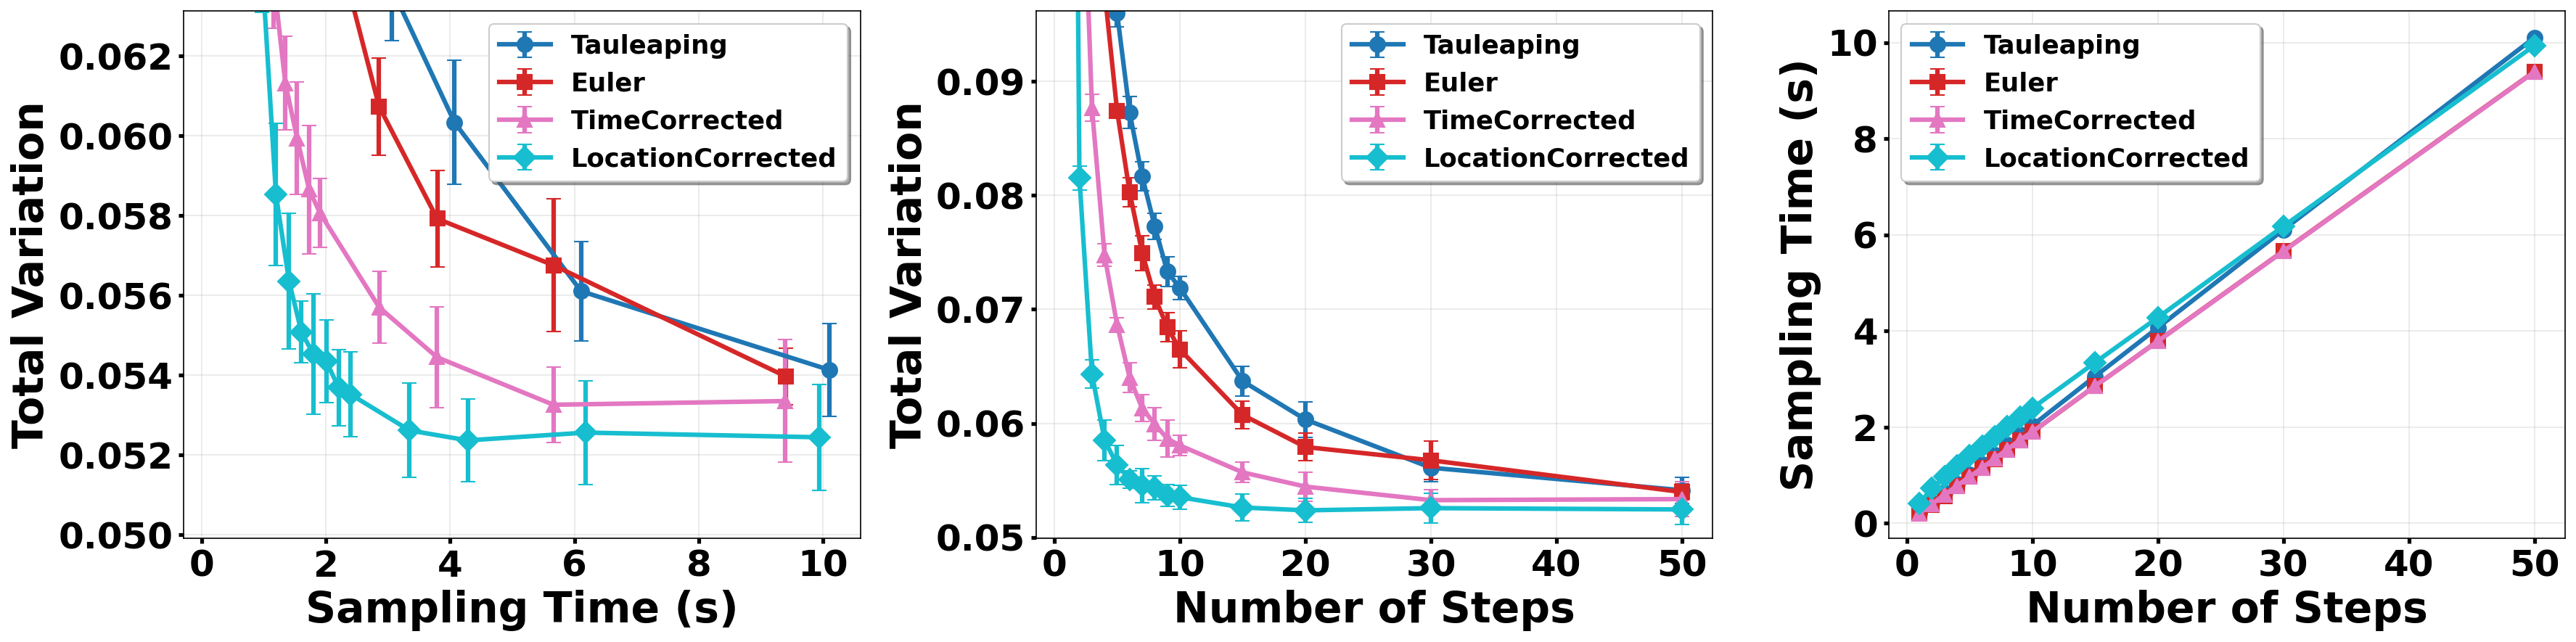

Saved: figure/uniform_source_dimension_3_comparison.pdf


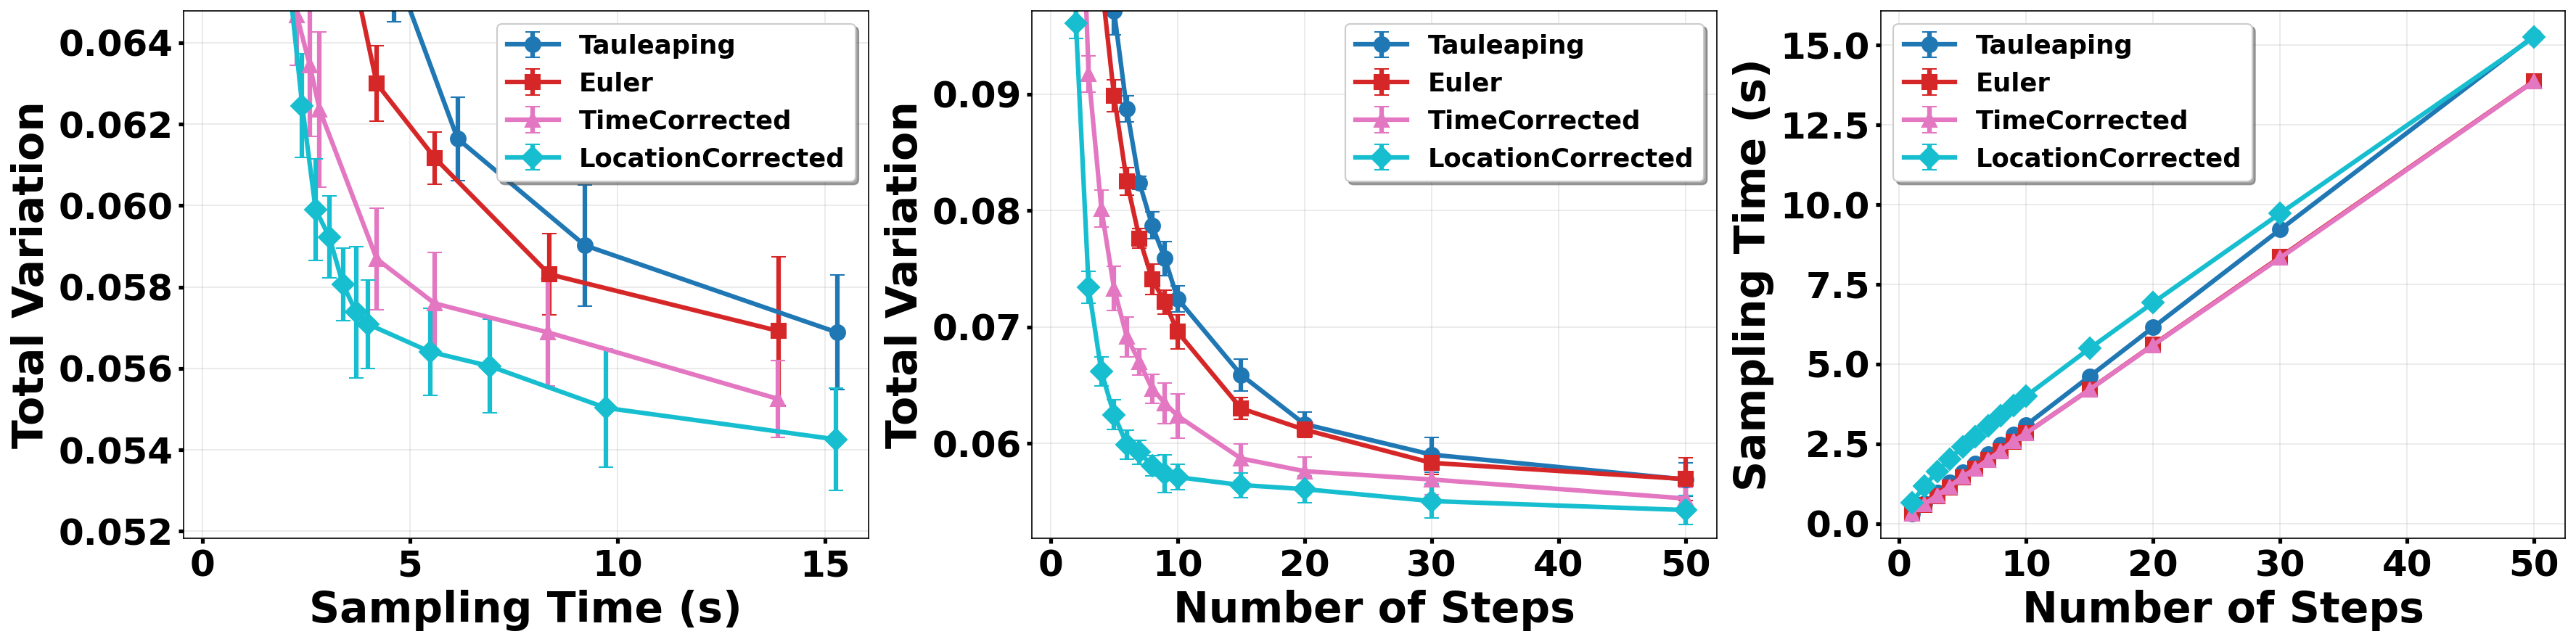

Saved: figure/uniform_source_dimension_6_comparison.pdf


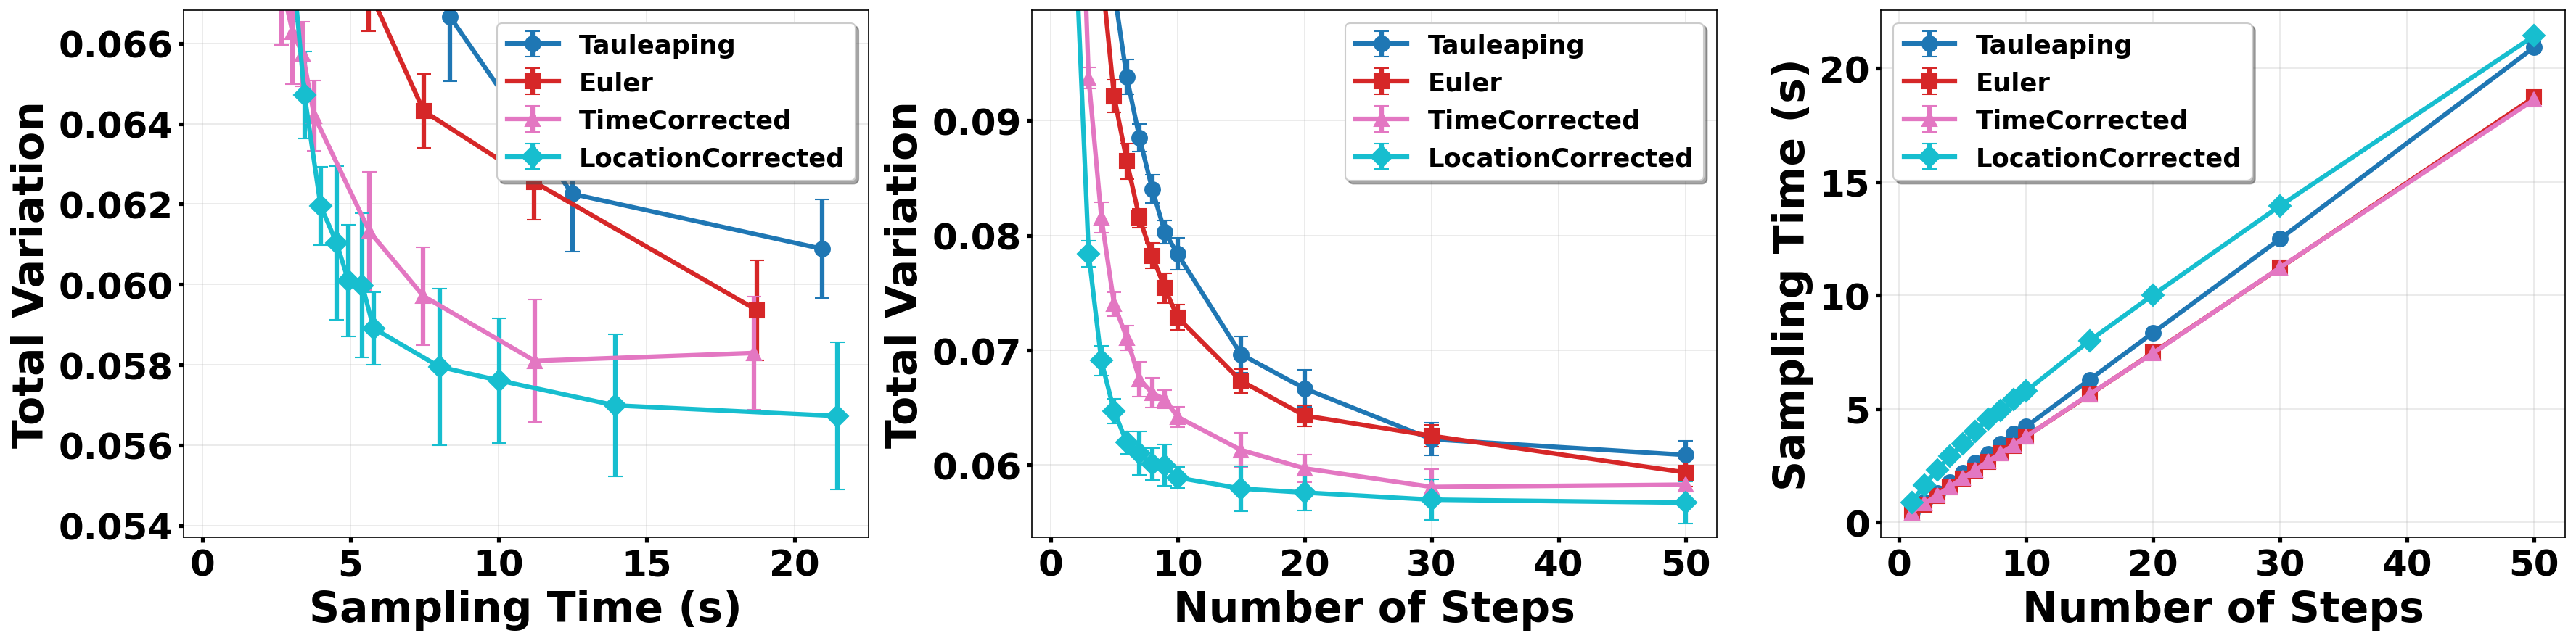

Saved: figure/uniform_source_dimension_9_comparison.pdf


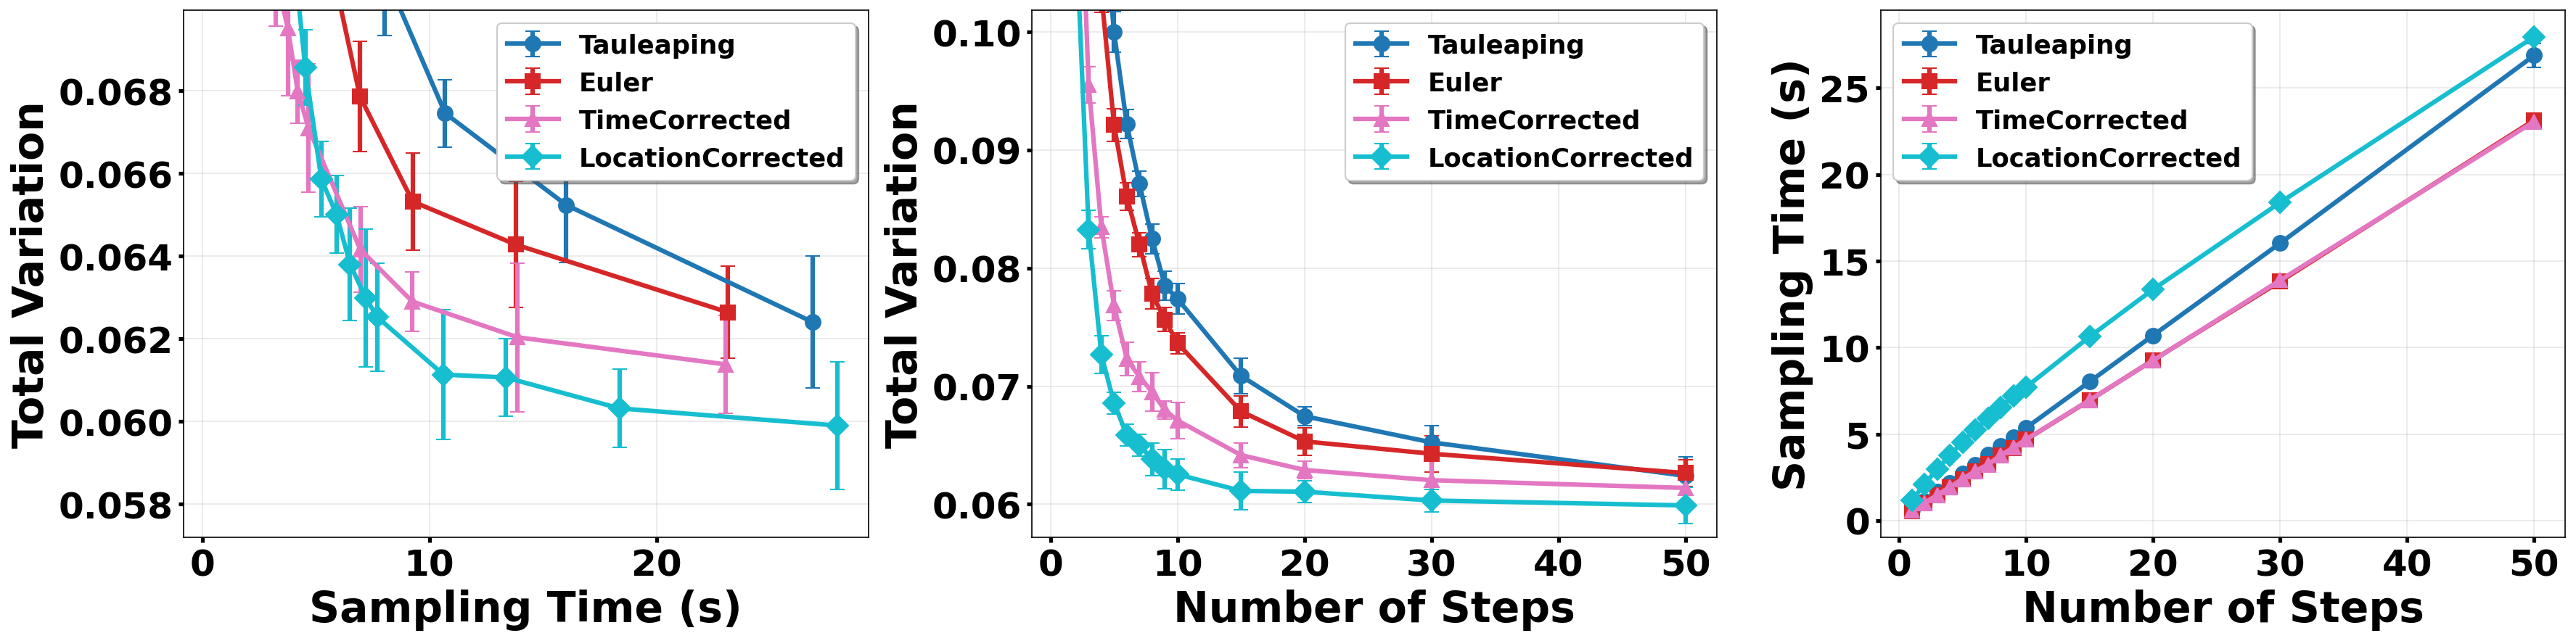

Saved: figure/uniform_source_dimension_12_comparison.pdf


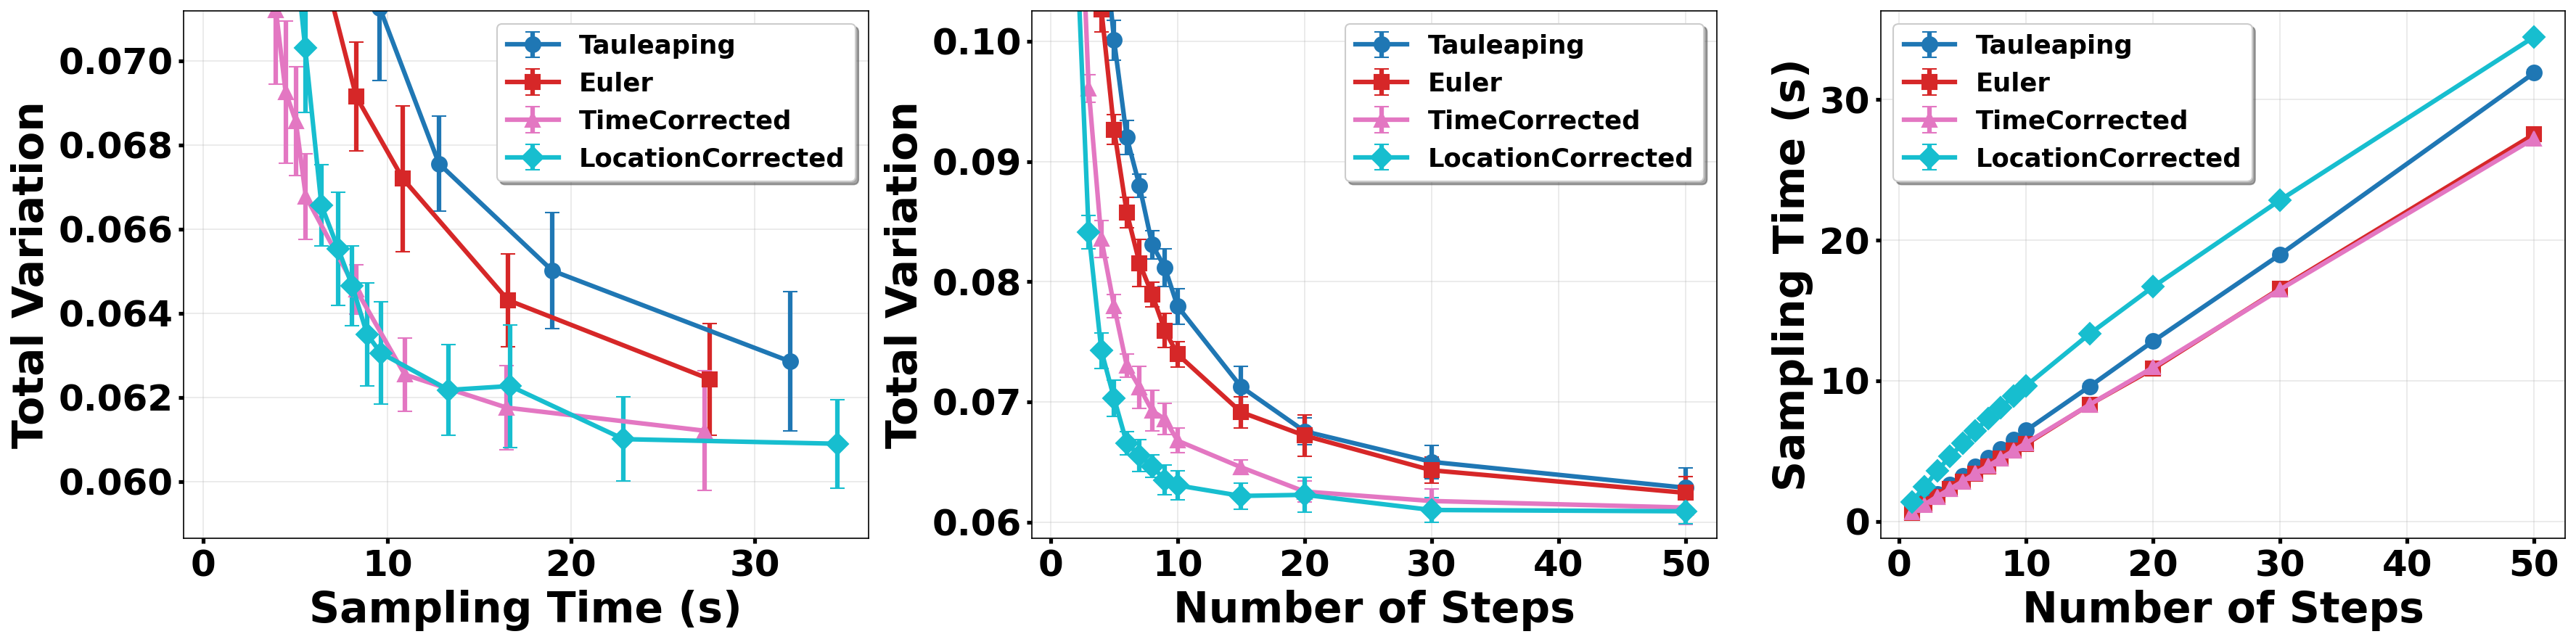

Saved: figure/uniform_source_dimension_15_comparison.pdf

All figures generated successfully!
Generated files:
  - figure/uniform_source_dimension_3_comparison.pdf
  - figure/uniform_source_dimension_6_comparison.pdf
  - figure/uniform_source_dimension_9_comparison.pdf
  - figure/uniform_source_dimension_12_comparison.pdf
  - figure/uniform_source_dimension_15_comparison.pdf


In [2]:
# Load data from CSV
csv_filename = "tv_time_all_results_uniform.csv"
df = pd.read_csv(csv_filename)

# Configuration
k_values = [1, 2, 3, 4, 5]
N_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50]
samplers = ['Tauleaping', 'Euler', 'TimeCorrected', 'LocationCorrected']

os.makedirs("figure", exist_ok=True)

colors = plt.cm.tab10(np.linspace(0, 1, len(samplers)))
markers = ['o', 's', '^', 'D', 'v']

# Generate separate figure for each dimension
for k in k_values:
    dimension = 3 * k
    
    # Create 1 row x 3 columns subplot with higher DPI
    fig, axes = plt.subplots(1, 3, figsize=(24, 6), dpi=150)
    
    # ============================================================================
    # Column 1: TV vs Time
    # ============================================================================
    ax1 = axes[0]
    
    for idx, sampler in enumerate(samplers):
        # Filter data for this k and sampler
        mask = (df['k'] == k) & (df['sampler'] == sampler)
        data = df[mask].sort_values('N')
        
        if not data.empty:
            tv_means = data['tv_mean'].values
            tv_stds = data['tv_std'].values
            time_means = data['time_mean'].values
            
            ax1.errorbar(time_means, tv_means, yerr=tv_stds,
                        marker=markers[idx],
                        linewidth=3,
                        markersize=10,
                        capsize=5,
                        color=colors[idx],
                        label=sampler)
    
    # Set y-axis range to show only lower half
    y_min, y_max = ax1.get_ylim()
    y_mid = (y_min + y_max) / 2
    ax1.set_ylim(y_min + (y_mid - y_min) * 0.08, y_min + (y_mid - y_min) * 0.2)
    
    ax1.set_xlabel('Sampling Time (s)', fontsize=28, fontweight='bold')
    ax1.set_ylabel('Total Variation', fontsize=28, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=17, loc='best', frameon=True, shadow=True)
    for text in ax1.get_legend().get_texts():
        text.set_fontweight('bold')
    ax1.tick_params(axis='both', labelsize=24, width=2.5)
    # Make tick labels bold
    for label in ax1.get_xticklabels() + ax1.get_yticklabels():
        label.set_fontweight('bold')
    
    # ============================================================================
    # Column 2: TV vs N
    # ============================================================================
    ax2 = axes[1]
    
    for idx, sampler in enumerate(samplers):
        mask = (df['k'] == k) & (df['sampler'] == sampler)
        data = df[mask].sort_values('N')
        
        if not data.empty:
            valid_N = data['N'].values
            tv_means = data['tv_mean'].values
            tv_stds = data['tv_std'].values
            
            ax2.errorbar(valid_N, tv_means, yerr=tv_stds,
                        marker=markers[idx],
                        linewidth=3,
                        markersize=10,
                        capsize=5,
                        color=colors[idx],
                        label=sampler)
    
    # Set y-axis range
    y_min, y_max = ax2.get_ylim()
    y_mid = (y_min + y_max) / 2
    ax2.set_ylim(y_min + (y_mid - y_min) * 0.08, y_min + (y_mid - y_min) * 0.5)
    
    ax2.set_xlabel('Number of Steps', fontsize=28, fontweight='bold')
    ax2.set_ylabel('Total Variation', fontsize=28, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=17, loc='best', frameon=True, shadow=True)
    for text in ax2.get_legend().get_texts():
        text.set_fontweight('bold')
    ax2.tick_params(axis='both', labelsize=24, width=2.5)
    for label in ax2.get_xticklabels() + ax2.get_yticklabels():
        label.set_fontweight('bold')
    
    # ============================================================================
    # Column 3: Time vs N
    # ============================================================================
    ax3 = axes[2]
    
    for idx, sampler in enumerate(samplers):
        mask = (df['k'] == k) & (df['sampler'] == sampler)
        data = df[mask].sort_values('N')
        
        if not data.empty:
            valid_N = data['N'].values
            time_means = data['time_mean'].values
            time_stds = data['time_std'].values
            
            ax3.errorbar(valid_N, time_means, yerr=time_stds,
                        marker=markers[idx],
                        linewidth=3,
                        markersize=10,
                        capsize=5,
                        color=colors[idx],
                        label=sampler)
    
    ax3.set_xlabel('Number of Steps', fontsize=28, fontweight='bold')
    ax3.set_ylabel('Sampling Time (s)', fontsize=28, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=17, loc='best', frameon=True, shadow=True)
    for text in ax3.get_legend().get_texts():
        text.set_fontweight('bold')
    ax3.tick_params(axis='both', labelsize=24, width=2.5)
    for label in ax3.get_xticklabels() + ax3.get_yticklabels():
        label.set_fontweight('bold')
    
    # Save without any titles
    plt.tight_layout()
    
    pdf_filename = f"figure/uniform_source_dimension_{dimension}_comparison.pdf"
    plt.savefig(pdf_filename, format='pdf', bbox_inches='tight', dpi=600)
    plt.show()
    
    print(f"Saved: {pdf_filename}")

print("\n" + "="*80)
print("All figures generated successfully!")
print("="*80)
print("Generated files:")
for k in k_values:
    print(f"  - figure/uniform_source_dimension_{3*k}_comparison.pdf")

# Summary: 1,2) location-corrected sampler is the best; 
# 3) For location-corrected sampler, the ratio of additional computational cost over Euler sampler decreases as k increases.

### Masked source distribution

In [2]:

vocab_size = 9
mask_token = 8
delta = 0.05
scheduler = PolynomialConvexScheduler(n=1)
path = MixtureDiscreteProbPath(scheduler=scheduler)


def total_variation(p, q):
    return 0.5 * np.sum(np.abs(p - q))

n_samples_eval = 100000
n_repeats = 10  
k_values = [1, 2, 3, 4, 5]  
N_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50]
samplers = ['Tauleaping','Euler','TimeCorrected','LocationCorrected']

# Store TV results: dict[k] -> dict[sampler_name] -> list[tv_values]
tv_results = {k: {name: {} for name in samplers} for k in k_values}
# Store timing results
time_results = {k: {name: {} for name in samplers} for k in k_values}

# function to convert joint state to index
def joint_to_index(joint_data):
    return joint_data[:, 0] * (8 ** 2) + joint_data[:, 1] * 8 + joint_data[:, 2]

# Joint state space size
joint_space_size = 8 ** 3


for k in k_values:
    dimension = 3 * k
    # Generate ground truth: real data empirical distribution
    real_data_cache = generate_3k_discrete_data(n=1000000, K=k)
    real_joint = real_data_cache[:, :3]
    real_indices = joint_to_index(real_joint)
    # Compute real distribution (ground truth)
    unique_values_real, counts_real = np.unique(real_indices, return_counts=True)
    probs_real_full = np.zeros(joint_space_size)
    for val, prob in zip(unique_values_real, counts_real / len(real_indices)):
        probs_real_full[int(val)] = prob
    
    # Load model (only once per k)
    logit_model = ToyMLP(vocab_size=vocab_size, hidden_dim=256, length=dimension, time_dim=0)
    model_path = os.path.join("./ckpts", f"toy_uniform_{k}_step200000", f"ckpt.pth")

    if not os.path.exists(model_path):
        print(f"Model not found at {model_path}")
        continue
    
    ckpt_posterior = torch.load(model_path, map_location=device)
    logit_model.load_state_dict(ckpt_posterior)
    logit_model.eval()
    posterior_model = WrappedModel(logit_model)
    
    for N_step in N_values:
        print(f"\n  N={N_step}")

        for sampler in samplers:
            print(f"Processing sampler = {sampler}")
            tv_list = []
            time_list = []
            for rep in range(n_repeats):
                x_init = (torch.zeros(size=(n_samples_eval, dimension), device=device) + mask_token).long()
                with torch.no_grad():
                    start_time = time.time()
                    if sampler == 'Uniformization':
                        solver = MixtureDiscreteUniformizationSolver(
                            model=posterior_model, path=path, vocabulary_size=vocab_size)
                        sol, _ = solver.sample(x_init=x_init, delta=delta, verbose=False, mask=True)
                        
                    elif sampler == 'Tauleaping':
                        solver = MixtureDiscreteTauleapingSolver(
                            model=posterior_model, path=path, vocabulary_size=vocab_size)
                        sol, _ = solver.sample(x_init=x_init, N=N_step, delta=delta, verbose=False, mask=True)
                        
                    elif sampler == 'Euler':
                        solver = MixtureDiscreteEulerSolver(
                            model=posterior_model, path=path, vocabulary_size=vocab_size)
                        sol, _ = solver.sample(x_init=x_init, N=N_step, delta=delta, verbose=False, mask=True)

                    elif sampler == 'TimeCorrected':
                        solver = MixtureDiscreteTimeCorrectedSolver(
                            model=posterior_model, path=path, vocabulary_size=vocab_size)
                        sol, _ = solver.sample(x_init=x_init, N=N_step, delta=delta, verbose=False, mask=True)
                        
                    elif sampler == 'LocationCorrected':
                        solver = MixtureDiscreteLocationCorrectedSolver(
                            model=posterior_model, path=path, vocabulary_size=vocab_size)
                        sol, _ = solver.sample(x_init=x_init, N=N_step, delta=delta, verbose=False, mask=True)

                    sample_time = time.time() - start_time
                    # Compute empirical distribution of generated samples
                    sol_joint = sol[:, :3].cpu().numpy()
                    sol_indices = joint_to_index(sol_joint)
                    unique_values_sol, counts_sol = np.unique(sol_indices, return_counts=True)
                    probs_sol_full = np.zeros(joint_space_size)
                    for val, prob in zip(unique_values_sol, counts_sol / len(sol_indices)):
                        probs_sol_full[int(val)] = prob
                    
                    # Compute TV distance
                    tv = total_variation(probs_real_full, probs_sol_full)

                    tv_list.append(tv)
                    time_list.append(sample_time)
            # Average over repeats
            tv_mean = np.mean(tv_list)
            tv_std = np.std(tv_list)
            time_mean = np.mean(time_list)
            time_std = np.std(time_list)
            tv_results[k][sampler][N_step] = {'mean': tv_mean, 'std': tv_std, 'all': tv_list}
            time_results[k][sampler][N_step] = {'mean': time_mean, 'std': time_std, 'all': time_list}

            print(f"  k={k}, Sampler={sampler}, N_step={N_step}, TV={tv_mean:.6f}±{tv_std:.6f}, Time={time_mean:.2f}±{time_std:.2f}s")
# Save to CSV
csv_filename = "tv_time_all_results_mask.csv"
with open(csv_filename, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["k", "dimension", "N", "sampler", "tv_mean", "tv_std", "time_mean", "time_std"])
    for k in k_values:
        for N in N_values:
            for sampler in samplers:
                res_tv = tv_results[k][sampler].get(N)
                res_time = time_results[k][sampler].get(N)
                if res_tv is not None and res_time is not None:
                    writer.writerow([k, 3*k, N, sampler, 
                                     res_tv['mean'], res_tv['std'],
                                     res_time['mean'], res_time['std']])
                else:
                    writer.writerow([k, 3*k, N, sampler, None, None, None, None])


print(f"\n{'='*80}")
print(f"CSV file saved: {csv_filename}")
print(f"{'='*80}")


  N=1
Processing sampler = Tauleaping
  k=1, Sampler=Tauleaping, N_step=1, TV=0.136282±0.000963, Time=0.40±0.03s
Processing sampler = Euler
  k=1, Sampler=Euler, N_step=1, TV=0.131391±0.001083, Time=0.38±0.02s
Processing sampler = TimeCorrected
  k=1, Sampler=TimeCorrected, N_step=1, TV=0.219114±0.001241, Time=0.40±0.02s
Processing sampler = LocationCorrected
  k=1, Sampler=LocationCorrected, N_step=1, TV=0.079641±0.001627, Time=0.58±0.03s

  N=2
Processing sampler = Tauleaping
  k=1, Sampler=Tauleaping, N_step=2, TV=0.119247±0.001387, Time=0.59±0.02s
Processing sampler = Euler
  k=1, Sampler=Euler, N_step=2, TV=0.104002±0.001313, Time=0.56±0.02s
Processing sampler = TimeCorrected
  k=1, Sampler=TimeCorrected, N_step=2, TV=0.156553±0.001183, Time=0.56±0.02s
Processing sampler = LocationCorrected
  k=1, Sampler=LocationCorrected, N_step=2, TV=0.055298±0.000953, Time=0.85±0.04s

  N=3
Processing sampler = Tauleaping
  k=1, Sampler=Tauleaping, N_step=3, TV=0.107921±0.001830, Time=0.77±0.

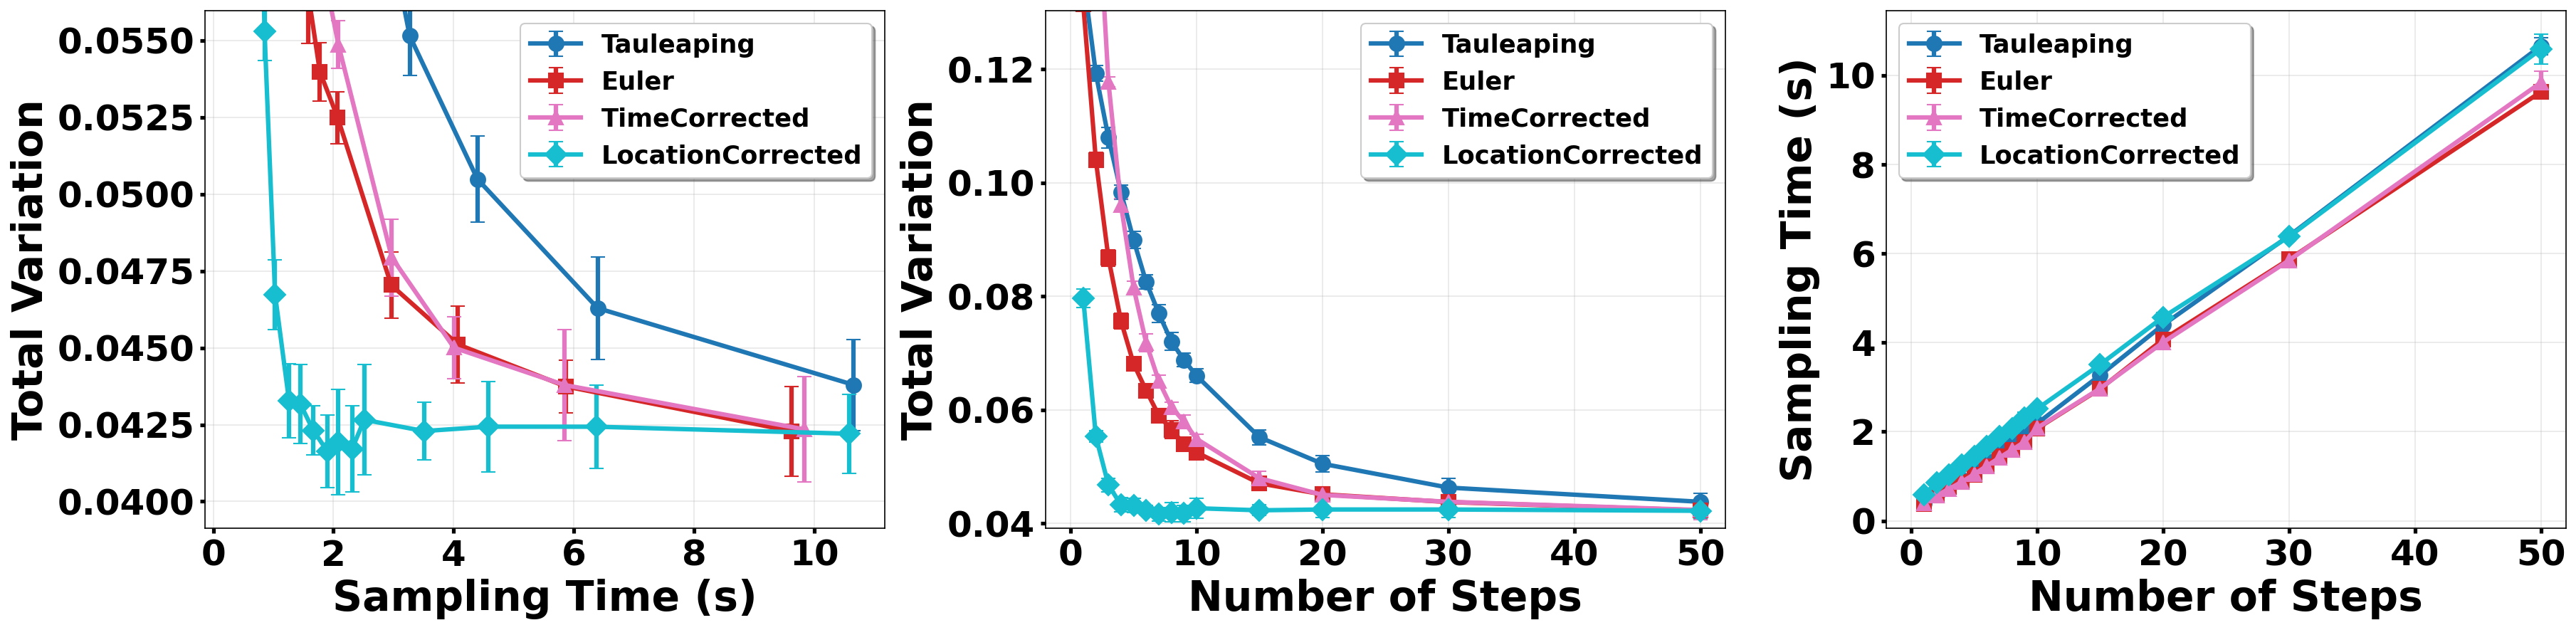

Saved: figure/mask_source_dimension_3_comparison.pdf


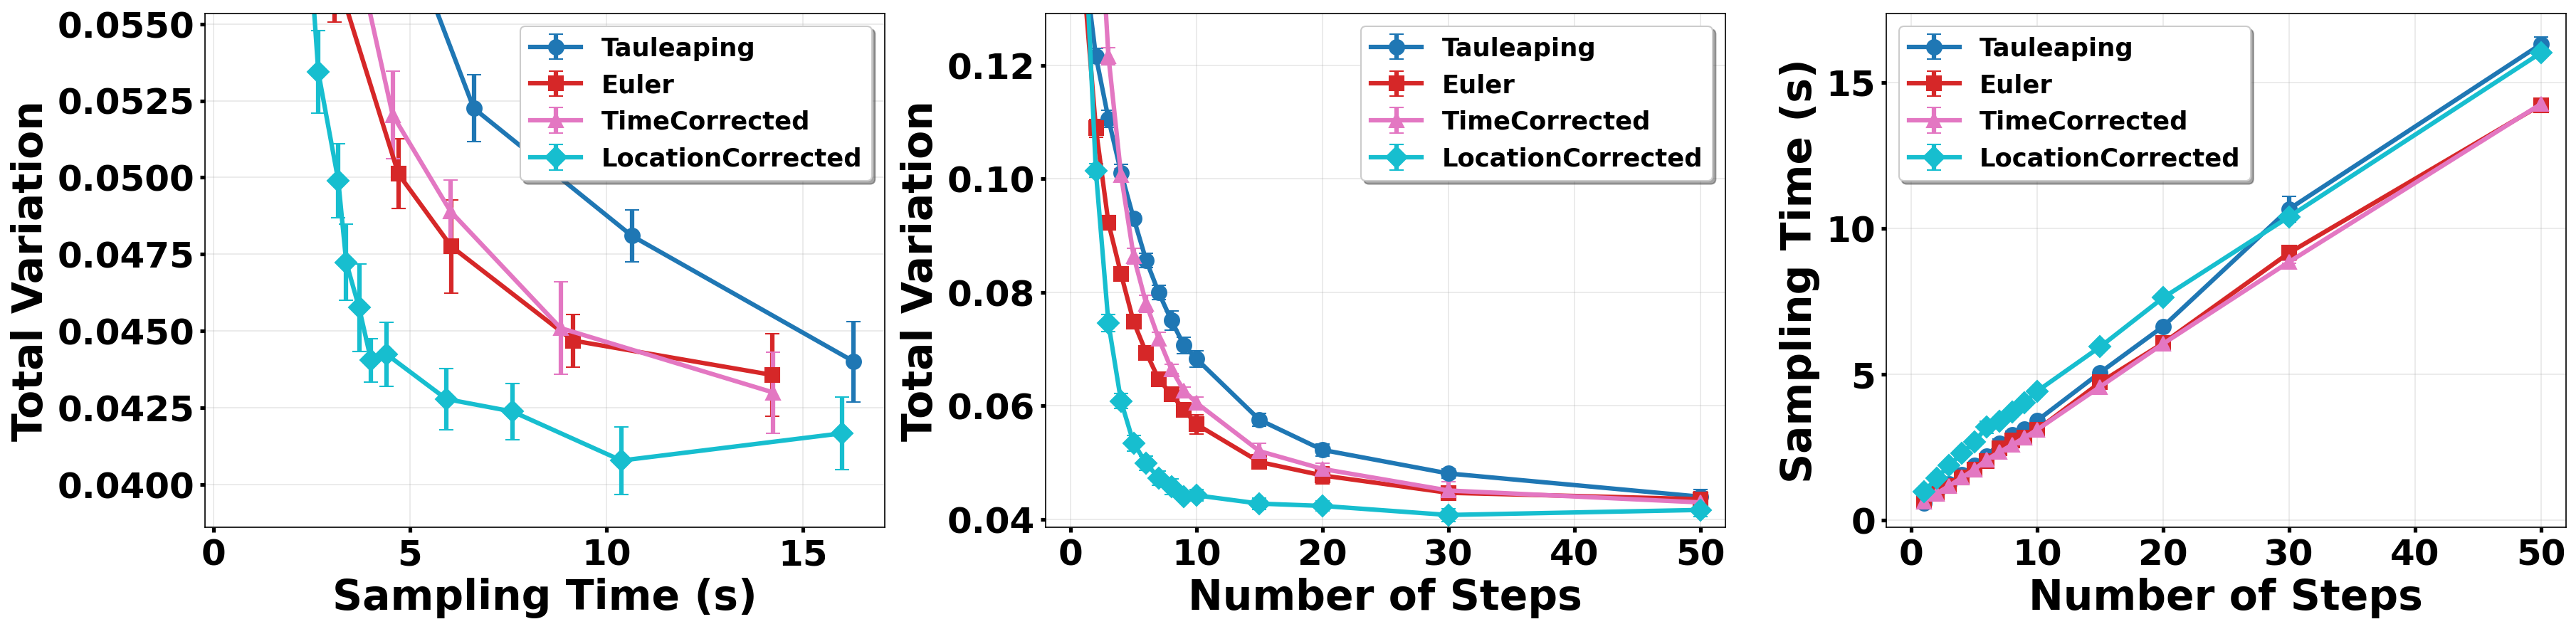

Saved: figure/mask_source_dimension_6_comparison.pdf


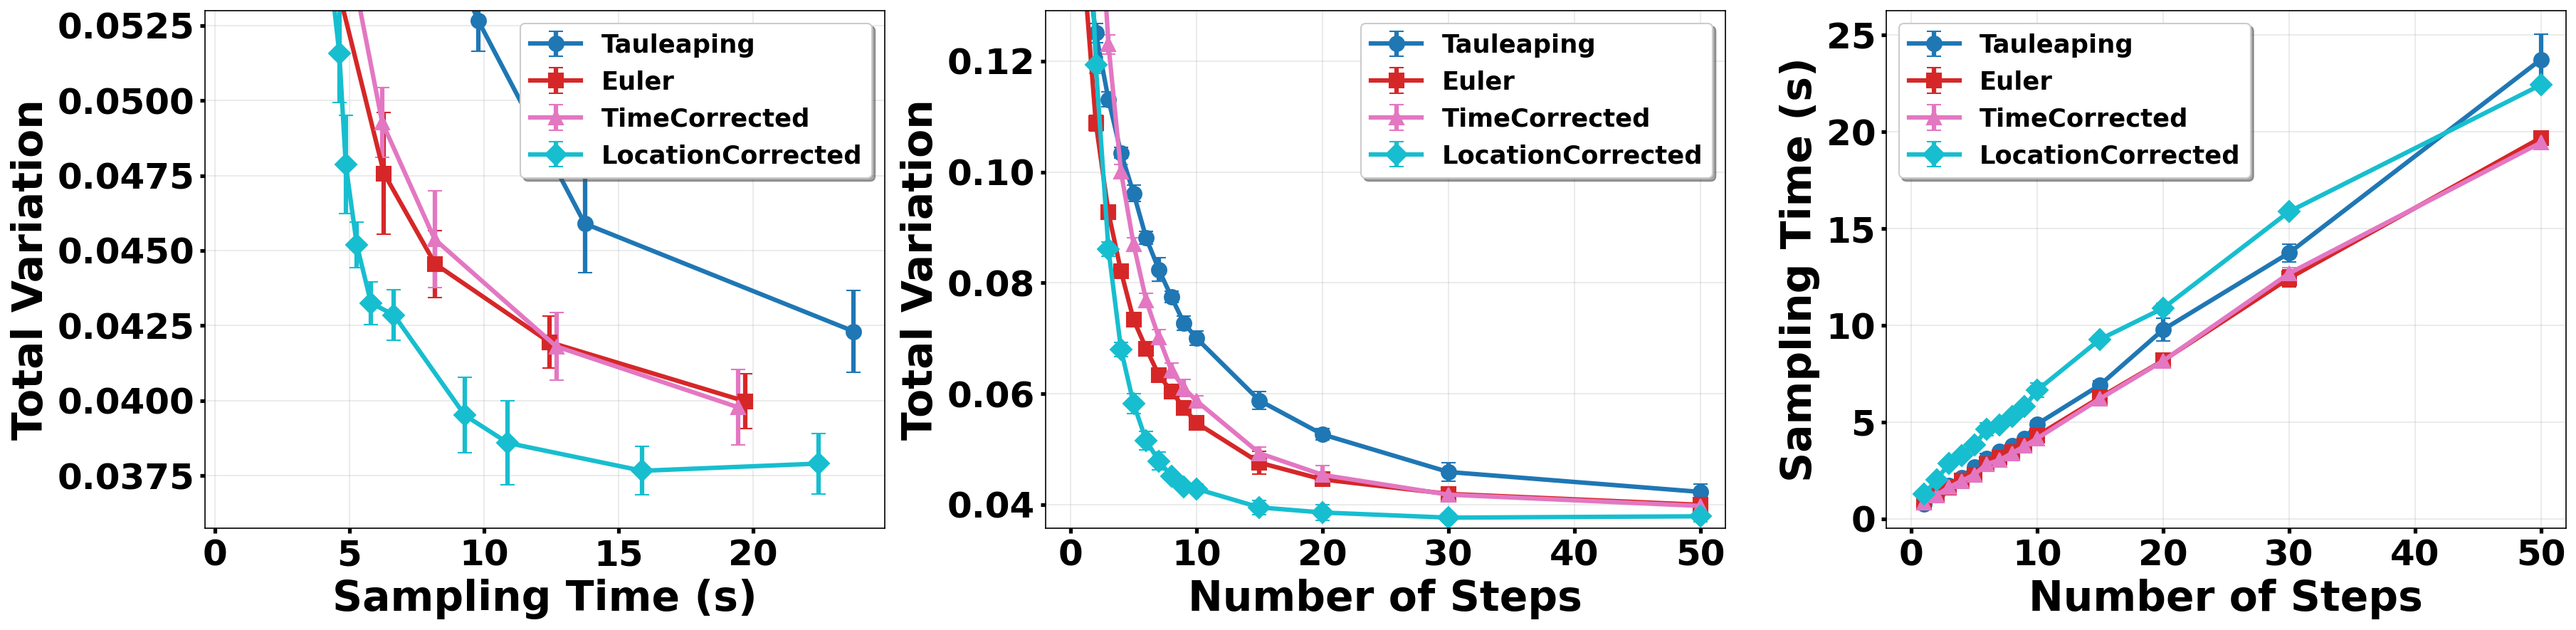

Saved: figure/mask_source_dimension_9_comparison.pdf


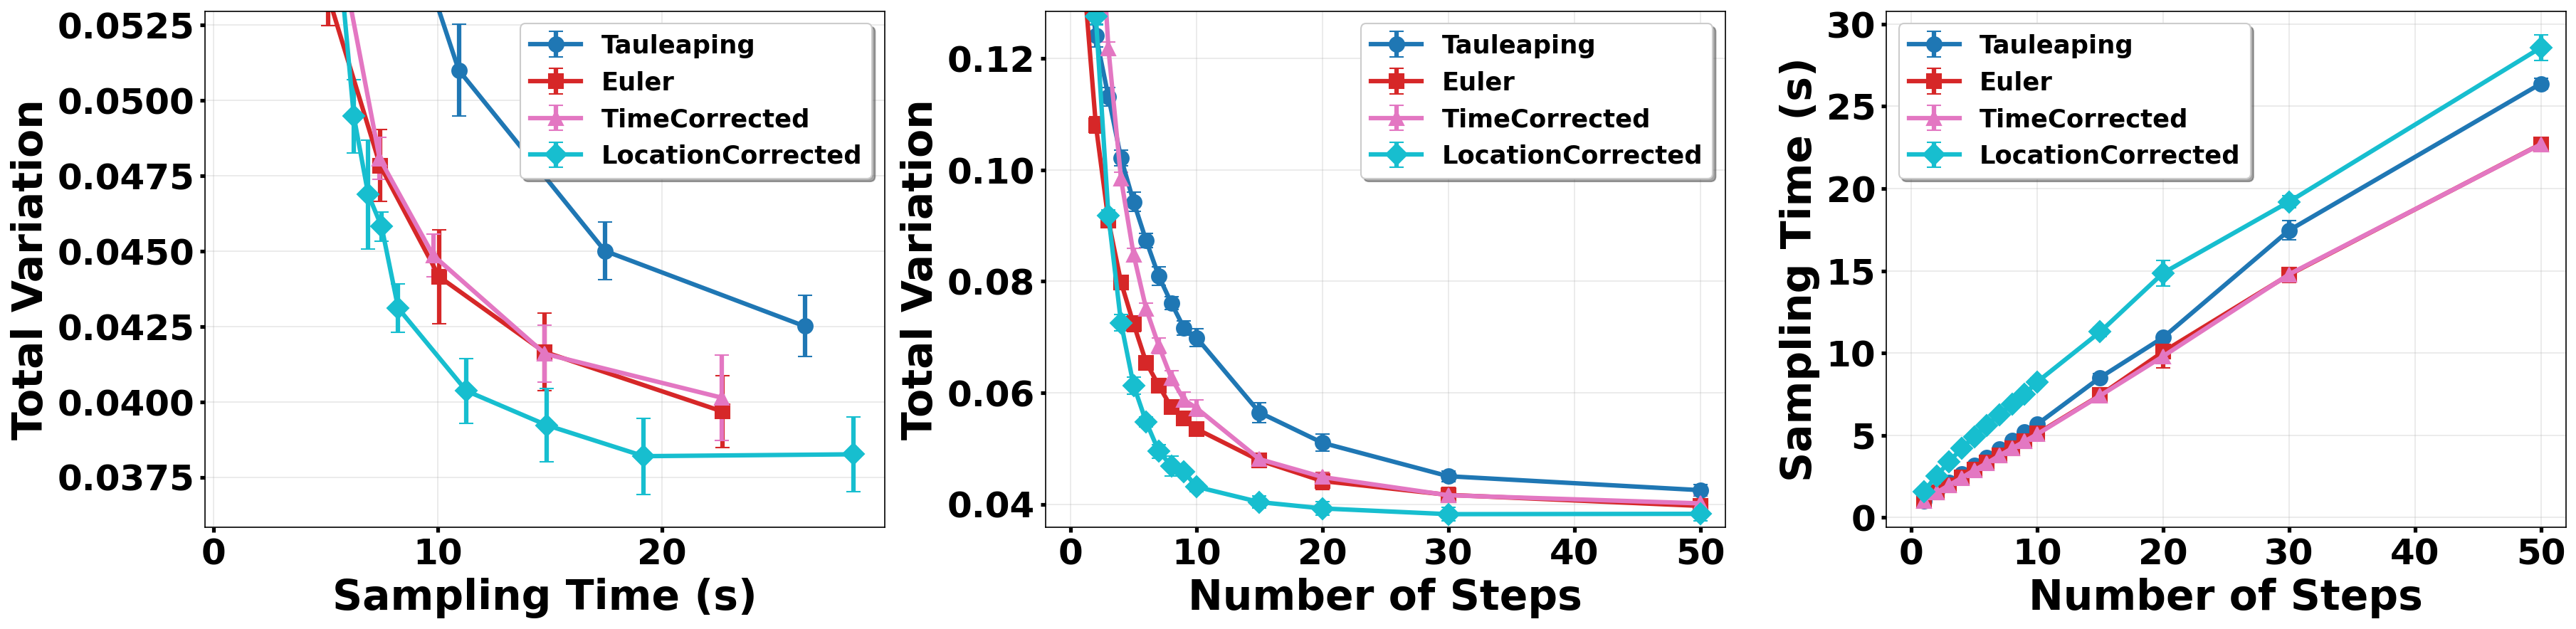

Saved: figure/mask_source_dimension_12_comparison.pdf


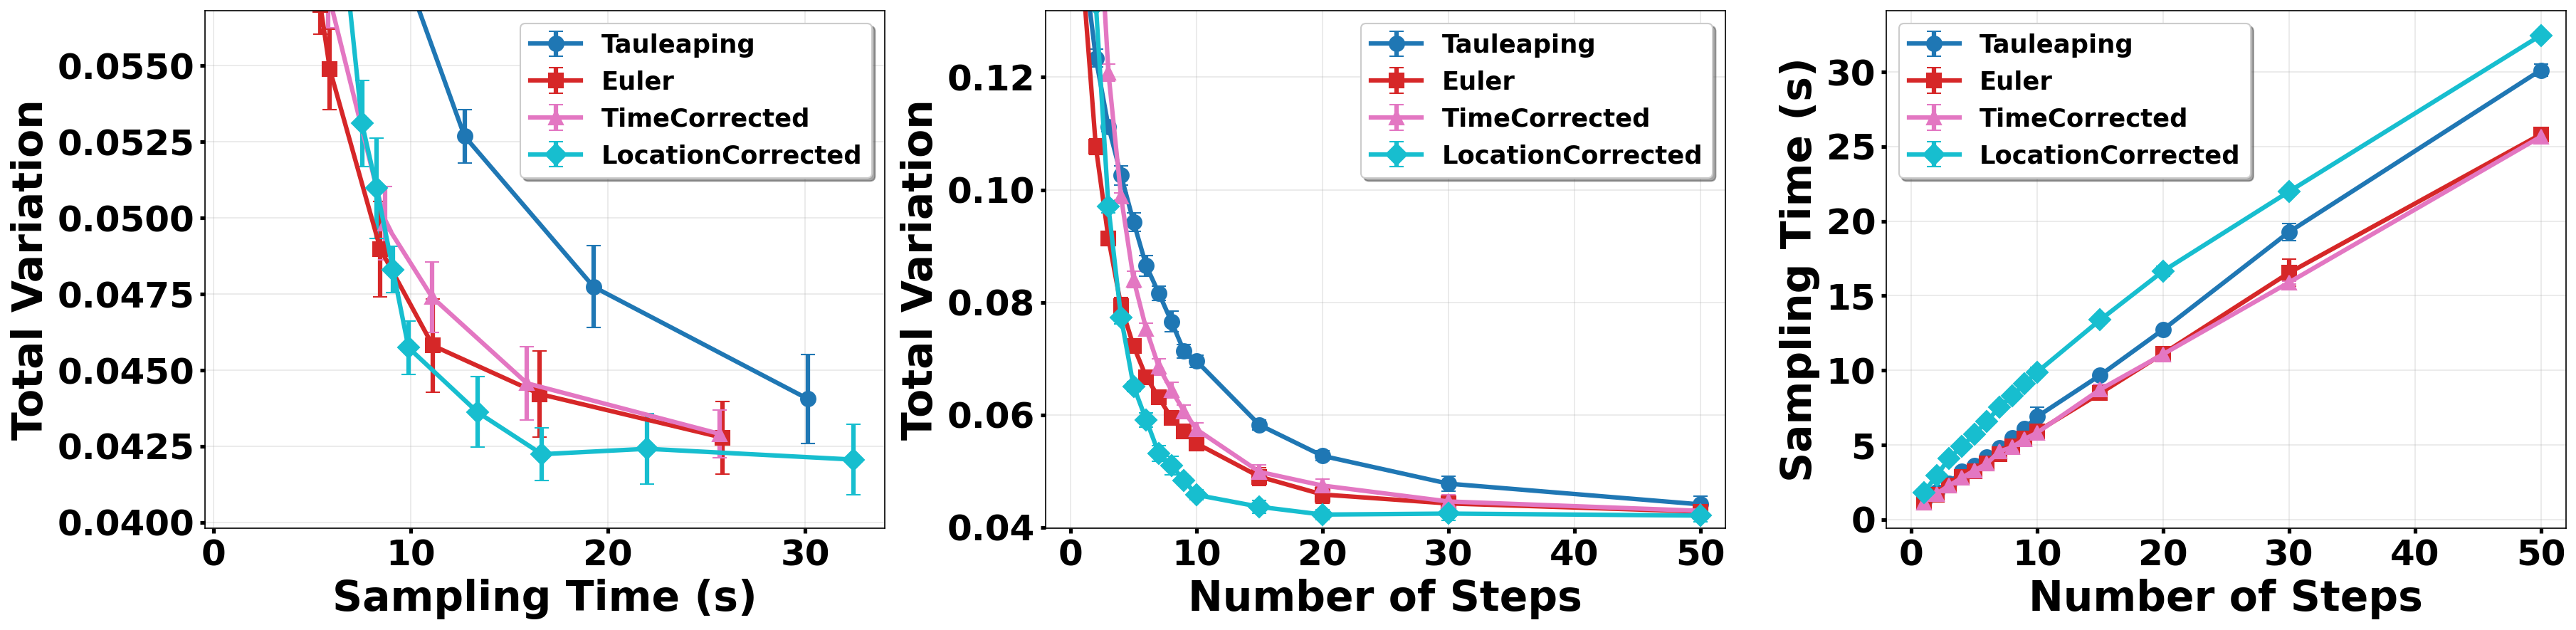

Saved: figure/mask_source_dimension_15_comparison.pdf

All figures generated successfully!
Generated files:
  - figure/mask_source_dimension_3_comparison.pdf
  - figure/mask_source_dimension_6_comparison.pdf
  - figure/mask_source_dimension_9_comparison.pdf
  - figure/mask_source_dimension_12_comparison.pdf
  - figure/mask_source_dimension_15_comparison.pdf


In [3]:
# Load data from CSV
csv_filename = "tv_time_all_results_mask.csv"
df = pd.read_csv(csv_filename)

# Configuration
k_values = [1, 2, 3, 4, 5]
N_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50]
samplers = ['Tauleaping', 'Euler', 'TimeCorrected', 'LocationCorrected']

os.makedirs("figure", exist_ok=True)

colors = plt.cm.tab10(np.linspace(0, 1, len(samplers)))
markers = ['o', 's', '^', 'D', 'v']

# Generate separate figure for each dimension
for k in k_values:
    dimension = 3 * k
    
    # Create 1 row x 3 columns subplot with higher DPI
    fig, axes = plt.subplots(1, 3, figsize=(24, 6), dpi=150)
    
    # ============================================================================
    # Column 1: TV vs Time
    # ============================================================================
    ax1 = axes[0]
    
    for idx, sampler in enumerate(samplers):
        # Filter data for this k and sampler
        mask = (df['k'] == k) & (df['sampler'] == sampler)
        data = df[mask].sort_values('N')
        
        if not data.empty:
            tv_means = data['tv_mean'].values
            tv_stds = data['tv_std'].values
            time_means = data['time_mean'].values
            
            ax1.errorbar(time_means, tv_means, yerr=tv_stds,
                        marker=markers[idx],
                        linewidth=3,
                        markersize=10,
                        capsize=5,
                        color=colors[idx],
                        label=sampler)
    
    # Set y-axis range to show only lower half
    y_min, y_max = ax1.get_ylim()
    y_mid = (y_min + y_max) / 2
    ax1.set_ylim(y_min + (y_mid - y_min) * 0.08, y_min + (y_mid - y_min) * 0.25)
    
    ax1.set_xlabel('Sampling Time (s)', fontsize=28, fontweight='bold')
    ax1.set_ylabel('Total Variation', fontsize=28, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=17, loc='best', frameon=True, shadow=True)
    for text in ax1.get_legend().get_texts():
        text.set_fontweight('bold')
    ax1.tick_params(axis='both', labelsize=24, width=2.5)
    for label in ax1.get_xticklabels() + ax1.get_yticklabels():
        label.set_fontweight('bold')
    
    # ============================================================================
    # Column 2: TV vs N
    # ============================================================================
    ax2 = axes[1]
    
    for idx, sampler in enumerate(samplers):
        mask = (df['k'] == k) & (df['sampler'] == sampler)
        data = df[mask].sort_values('N')
        
        if not data.empty:
            valid_N = data['N'].values
            tv_means = data['tv_mean'].values
            tv_stds = data['tv_std'].values
            
            ax2.errorbar(valid_N, tv_means, yerr=tv_stds,
                        marker=markers[idx],
                        linewidth=3,
                        markersize=10,
                        capsize=5,
                        color=colors[idx],
                        label=sampler)
    
    # Set y-axis range
    y_min, y_max = ax2.get_ylim()
    y_mid = (y_min + y_max) / 2
    ax2.set_ylim(y_min + (y_mid - y_min) * 0.08, y_min + (y_mid - y_min) * 1)
    
    ax2.set_xlabel('Number of Steps', fontsize=28, fontweight='bold')
    ax2.set_ylabel('Total Variation', fontsize=28, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=17, loc='best', frameon=True, shadow=True)
    for text in ax2.get_legend().get_texts():
        text.set_fontweight('bold')
    ax2.tick_params(axis='both', labelsize=24, width=2.5)
    for label in ax2.get_xticklabels() + ax2.get_yticklabels():
        label.set_fontweight('bold')
    
    # ============================================================================
    # Column 3: Time vs N
    # ============================================================================
    ax3 = axes[2]
    
    for idx, sampler in enumerate(samplers):
        mask = (df['k'] == k) & (df['sampler'] == sampler)
        data = df[mask].sort_values('N')
        
        if not data.empty:
            valid_N = data['N'].values
            time_means = data['time_mean'].values
            time_stds = data['time_std'].values
            
            ax3.errorbar(valid_N, time_means, yerr=time_stds,
                        marker=markers[idx],
                        linewidth=3,
                        markersize=10,
                        capsize=5,
                        color=colors[idx],
                        label=sampler)
    
    ax3.set_xlabel('Number of Steps', fontsize=28, fontweight='bold')
    ax3.set_ylabel('Sampling Time (s)', fontsize=28, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=17, loc='best', frameon=True, shadow=True)
    for text in ax3.get_legend().get_texts():
        text.set_fontweight('bold')
    ax3.tick_params(axis='both', labelsize=24, width=2.5)
    for label in ax3.get_xticklabels() + ax3.get_yticklabels():
        label.set_fontweight('bold')
    

    ax2.set_xlim(-2, 52)
    ax3.set_xlim(-2, 52)
    
    # Save
    plt.tight_layout()
    pdf_filename = f"figure/mask_source_dimension_{dimension}_comparison.pdf"
    plt.savefig(pdf_filename, format='pdf', bbox_inches='tight', dpi=600)
    plt.show()
    
    print(f"Saved: {pdf_filename}")

print("\n" + "="*80)
print("All figures generated successfully!")
print("="*80)
print("Generated files:")
for k in k_values:
    print(f"  - figure/mask_source_dimension_{3*k}_comparison.pdf")

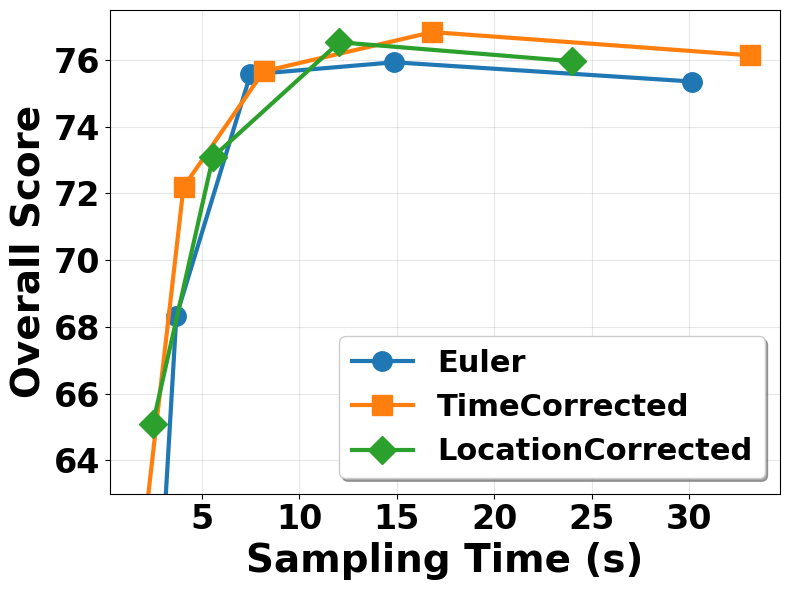

In [10]:
import matplotlib.pyplot as plt
import numpy as np


sampler = [
    "Euler", "TimeCorrected", "LocationCorrected",
    "Euler", "TimeCorrected", "LocationCorrected",
    "Euler", "TimeCorrected", "LocationCorrected",
    "Euler", "TimeCorrected", "LocationCorrected",
    "Euler", "TimeCorrected"  # New data points with steps=4
]
steps = [8,8,4, 16,16,8, 32,32,16, 64,64,32, 4, 4]
time = [3.70482, 4.07314, 2.50190, 7.50117, 8.17569, 5.58421, 14.87659, 16.82303, 12.06032, 30.14049, 33.08153, 23.95799, 1.85504, 2.01668]
overall = [68.321, 72.194, 65.100, 75.569, 75.660, 73.094, 75.933, 76.838, 76.533, 75.356, 76.143, 75.966, 49.998, 61.694]

sampler_map = {
    "Euler": {"color": "#1f77b4", "marker": "o", "label": "Euler"},
    "TimeCorrected": {"color": "#ff7f0e", "marker": "s", "label": "TimeCorrected"},
    "LocationCorrected": {"color": "#2ca02c", "marker": "D", "label": "LocationCorrected"},
}

plt.figure(figsize=(8,6))
for name in ["Euler", "TimeCorrected", "LocationCorrected"]:
    idx = [i for i, s in enumerate(sampler) if s == name]
    t = np.array(time)[idx]
    o = np.array(overall)[idx]
    sort_idx = np.argsort(t)
    t = t[sort_idx]
    o = o[sort_idx]
    plt.plot(
        t, o,
        label=sampler_map[name]["label"],
        marker=sampler_map[name]["marker"],
        color=sampler_map[name]["color"],
        linewidth=3,
        markersize=14
    )

plt.xlabel("Sampling Time (s)", fontsize=28, fontweight='bold')
plt.ylabel("Overall Score", fontsize=28, fontweight='bold')
plt.xticks(fontsize=24, fontweight='bold')
plt.yticks(fontsize=24, fontweight='bold')
plt.legend(fontsize=22, loc='lower right', frameon=True, shadow=True)
for text in plt.gca().get_legend().get_texts():
    text.set_fontweight('bold')
plt.ylim(63, 77.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("figure/sampling_time_vs_overall_score.pdf", format='pdf', bbox_inches='tight', dpi=600)
plt.show()